In [18]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import rasterio
import imageio
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont  # Keep the original PIL Image import
import rasterio.mask
from shapely.geometry import box
import geopandas as gpd
from pyproj import Transformer
import time
import shapely
import re
import datetime
import string
import geopandas
from IPython.display import display, clear_output
from IPython.display import Image as IPythonImage

<b> JUPYTER NOTEBOOK: </b>
Exploring the structure of a NetCDF file w/ variable length arrays

![alt text](https://s3.amazonaws.com/hr-challenge-images/14507/1476906485-2c93045320-variable-length-arrays.png)

For each lake, I have variable length (vlen) arrays of all my ice cover observations. Vlen data type can be constructed from ints, floats, or any other python type.

~ ~ ~ ~ ~ ~ ~

The NCDump command below is a quick way to output all the variables in a NetCDF file and show the overall file structure.  

![alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*p_i85nbMqMQAgTZ_4aexhA.png)

Reading below, the vlen_ types are just my variable types for vlen arrays

The lake dimension is the structure of my dataframe-- each lake in the "lake" dimension has a specific ID (I read these in from ALPOD) which lets me quickly add data based on where the ALPOD shapefile intersects with satellite imagery. The "lake" dimension actually was initiated with unlimited size, but I currently have 43929 entries for individual lakes calculated from my time series data. Usually dimensions are time and lat/lon, but since I wanted
my data organized by lake, I structured my dimensions around the ALPOD list IDs instead of usual spatiotemporal axes.

The other variables like lake_id, study_site, etc. are just normal variables associated with each lake. NetCDF can have variables of all the normal python types.  You can see these all have size of the (lake) dimension since each lake has each of these associated variables. I am working on adding another array variable contraining my red band rasters to the netcdf, so that each lake ID also contains vlen arrays of all the actual Surface Reflectance pixel observations recorded.

In [9]:
# Prints basic netcdf file data
!ncdump -h "D:/planetscope_lake_ice/Data (Unclassified)/2 - Break Up Time Series Output/lake_statistics.nc"

netcdf D\:\\planetscope_lake_ice\\Data\ \(Unclassified\)\\2\ -\ Break\ Up\ Time\ Series\ Output\\lake_statistics {
types:
  int(*) vlen_int32 ;
  float(*) vlen_float32 ;
dimensions:
	lake = 43929 ;
variables:
	int lake_id(lake) ;
	float area(lake) ;
	int total_pixels(lake) ;
	float perimeter(lake) ;
	string study_site(lake) ;
	vlen_int32 datetime(lake) ;
	string prefix(lake) ;
	vlen_int32 usable_pixels(lake) ;
	vlen_float32 clear_percent(lake) ;
	vlen_int32 ice_pixels(lake) ;
	vlen_float32 ice_percent(lake) ;
	vlen_int32 snow_pixels(lake) ;
	vlen_float32 snow_percent(lake) ;
	vlen_int32 water_pixels(lake) ;
	vlen_float32 water_percent(lake) ;
	int obs_count(lake) ;
		obs_count:long_name = "Number of observations for each lake" ;

// global attributes:
		:description = "Lake statistics with VLEN structure" ;
		:history = "Created on 2025-03-06 16:15:03\nConverted to VLEN structure" ;
		:time_format = "Unix timestamp (seconds since 1970-01-01 00:00:00 UTC)" ;
		:structure = "Each lake ha

In [5]:
# Set your NetCDF fileopath here
netcdf_path = r"D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.nc"

In [10]:
""" This script organizes the dataset by # of observations, and prints out the area for the 20 lakes which have the densest time series."""
# Open the NetCDF file
with nc.Dataset(netcdf_path, 'r') as ncfile:
    # Get lake IDs and observation counts
    lake_ids = ncfile.variables['lake_id'][:]
    observation_counts = ncfile.variables['obs_count'][:]
    areas = ncfile.variables['area'][:]
    study_sites = ncfile.variables['study_site'][:]

# Create a DataFrame
df = pd.DataFrame({
    'Lake ID': lake_ids,
    'Number of Observations': observation_counts,
    'Area': areas,
    'Study Site': study_sites
})

# Sort by number of observations in descending order
top_lakes = df.sort_values('Number of Observations', ascending=False).head(20)

print("Top 20 Lakes by Number of Observations:")
print(top_lakes.to_string(index=False))

# Calculate some statistics
total_lakes = len(lake_ids)
total_observations = observation_counts.sum()

print(f"\nTotal Lakes: {total_lakes}")
print(f"Total Observations: {total_observations}")
print(f"Average Observations per Lake: {total_observations/total_lakes:.2f}")

Top 20 Lakes by Number of Observations:
 Lake ID  Number of Observations         Area Study Site
  183702                      14  1895.513672        YKD
  183382                      14  1166.359863        YKD
  188131                      14 25501.548828        YKD
  188510                      14  1946.934814        YKD
  174110                      14  2713.836914        YKD
  188251                      14  6813.818359        YKD
  187864                      14  1265.306885        YKD
  188088                      14 13675.660156        YKD
  174156                      14  2713.887207        YKD
  188741                      14  9929.989258        YKD
  188062                      14  2141.407715        YKD
  188521                      14  1022.148315        YKD
  183602                      14 12684.851562        YKD
  188488                      14 14893.734375        YKD
  188105                      14 25842.943359        YKD
  185058                      14  5300.036133   

In [ ]:
"""This block is the function to print all data for a single lake, executed in the cell below."""

def check_lake_data(netcdf_path, lake_id=None):
    """
    Read and display lake data from a NetCDF file with VLEN data format.  

    Parameters:
    -----------
    netcdf_path : str
        Path to the NetCDF file.
    lake_id : int, optional
        Specific lake ID to inspect. If None, lists all lake IDs.
    """
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        # Get all lake IDs
        lake_ids = ncfile.variables['lake_id'][:]
        
        if lake_id is None:
            print("Available Lake IDs:")
            print(lake_ids)
            return
        
        # Find the index of the specified lake
        matches = np.where(lake_ids == lake_id)[0]
        if len(matches) == 0:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return
        lake_index = matches[0]
        
        # Print lake-level metadata
        print(f"\nLake ID: {lake_id}")
        print(f"Area: {ncfile.variables['area'][lake_index]:.2f} sq meters")
        # If available, print additional metadata
        if 'perimeter' in ncfile.variables:
            print(f"Perimeter: {ncfile.variables['perimeter'][lake_index]:.2f} meters")
        if 'study_site' in ncfile.variables:
            # Handle study_site, which might be stored as bytes or string
            study_site = ncfile.variables['study_site'][lake_index]
            if isinstance(study_site, bytes):
                study_site = study_site.decode('utf-8')
            print(f"Study Site: {study_site}")
        print(f"Total Pixels: {ncfile.variables['total_pixels'][lake_index]}")
        
        # Use obs_count for the number of observations
        obs_count = ncfile.variables['obs_count'][lake_index]
        print(f"Number of Observations: {obs_count}")
        
        if obs_count == 0:
            print("No observations found for this lake.")
            return
        
        # For VLEN arrays, each element is an array of varying length
        # We need to explicitly get each VLEN array for the current lake
        
        # Build the data dictionary for observations
        data = {}
        
        # For 'datetime' (stored as Unix timestamps)
        timestamps = ncfile.variables['datetime'][lake_index]
        data['Date (Unix)'] = timestamps
        
        # For 'prefix': it's likely a single string, not a comma-separated list
        prefix = ncfile.variables['prefix'][lake_index]
        if isinstance(prefix, bytes):
            prefix = prefix.decode('utf-8')
        
        # For all other numeric observation variables with VLEN format
        for var_name in ['usable_pixels', 'clear_percent', 'ice_pixels', 
                         'ice_percent', 'snow_pixels', 'snow_percent', 
                         'water_pixels', 'water_percent']:
            if var_name in ncfile.variables:
                data[var_name] = ncfile.variables[var_name][lake_index]
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Add human-readable datetime to the end
        df['datetime'] = df['Date (Unix)'].apply(
            lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
        )
        
        print("\nOBSERVATIONS ({}):".format(obs_count))
        print(df.to_string(index=False))

In [12]:
# CHOOSE YOUR LAKE NUMBER HERE
lake_id = 188088

# Runs above script to print out data for the requested lake ID (ID sourced from ALPOD)
check_lake_data(netcdf_path, lake_id)


Lake ID: 188088
Area: 13675.66 sq meters
Perimeter: 563.71 meters
Study Site: YKD
Total Pixels: 1502
Number of Observations: 14

OBSERVATIONS (14):
 Date (Unix)  usable_pixels  clear_percent  ice_pixels  ice_percent  snow_pixels  snow_percent  water_pixels  water_percent            datetime
  1620955724           1502          100.0        1462    97.336998            0      0.000000            40       2.663000 2021-05-13 21:28:44
  1621905770           1502          100.0           0     0.000000            0      0.000000          1502     100.000000 2021-05-24 21:22:50
  1621905773           1502          100.0           0     0.000000            0      0.000000          1502     100.000000 2021-05-24 21:22:53
  1621906230           1502          100.0           0     0.000000            0      0.000000          1502     100.000000 2021-05-24 21:30:30
  1621906232           1502          100.0           0     0.000000            0      0.000000          1502     100.000000 2021-05

In [ ]:
"""This block is the function to turn the data above into a time series graph"""

def plot_time_series_for_lake(netcdf_path, lake_id):
    """
    For a given lake_id, read the VLEN NetCDF file, group observations by year,
    and plot time series for ice, snow, and water percentages for each year with data.
    
    Parameters:
    -----------
    netcdf_path : str
        Path to the NetCDF file.
    lake_id : int
        The lake ID to plot data for.
    """
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        # Find the index of the specified lake
        lake_ids = ncfile.variables['lake_id'][:]
        matches = np.where(lake_ids == lake_id)[0]
        if len(matches) == 0:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return
        lake_index = matches[0]
        
        # Get number of observations for the lake
        obs_count = ncfile.variables['obs_count'][lake_index]
        if obs_count == 0:
            print(f"No observations found for lake ID {lake_id}.")
            return

        # Extract Unix timestamps and convert to datetime objects
        # (Assumes that the variable 'datetime' is stored as a VLEN array of Unix timestamps)
        time_data = ncfile.variables['datetime'][lake_index]
        datetimes = [datetime.datetime.fromtimestamp(ts) for ts in time_data]
        
        # Extract percentage variables for ice, snow, and water.
        # These variables are expected to be arrays of the same length as time_data.
        ice_percent = ncfile.variables['ice_percent'][lake_index]
        snow_percent = ncfile.variables['snow_percent'][lake_index]
        water_percent = ncfile.variables['water_percent'][lake_index]
        
        # Create a DataFrame with the data and add a year column
        df = pd.DataFrame({
            'datetime': datetimes,
            'ice_percent': ice_percent,
            'snow_percent': snow_percent,
            'water_percent': water_percent
        })
        df['year'] = df['datetime'].dt.year

    # Define colors for the plots
    ice_color   = '#87CEEB'
    snow_color  = '#FF8C00'
    water_color = '#0000FF'

    # Get unique years with observations
    unique_years = sorted(df['year'].unique())
    
    # Loop over each year and plot the time series if data exists for that year
    for year in unique_years:
        df_year = df[df['year'] == year]
        if df_year.empty:
            continue
        
        plt.figure(figsize=(10, 6))
        plt.plot(df_year['datetime'], df_year['ice_percent'], label='Ice %', 
                 color=ice_color, marker='o')
        plt.plot(df_year['datetime'], df_year['snow_percent'], label='Snow %', 
                 color=snow_color, marker='o')
        plt.plot(df_year['datetime'], df_year['water_percent'], label='Water %', 
                 color=water_color, marker='o')
        plt.xlabel('Date')
        plt.ylabel('Percentage')
        plt.title(f"Lake {lake_id} - Time Series for Year {year}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


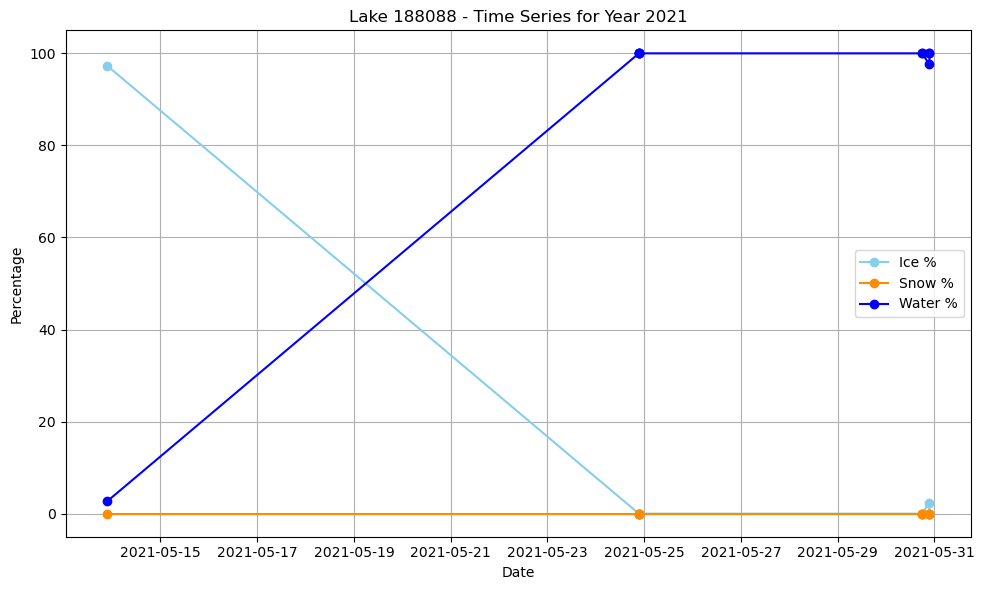

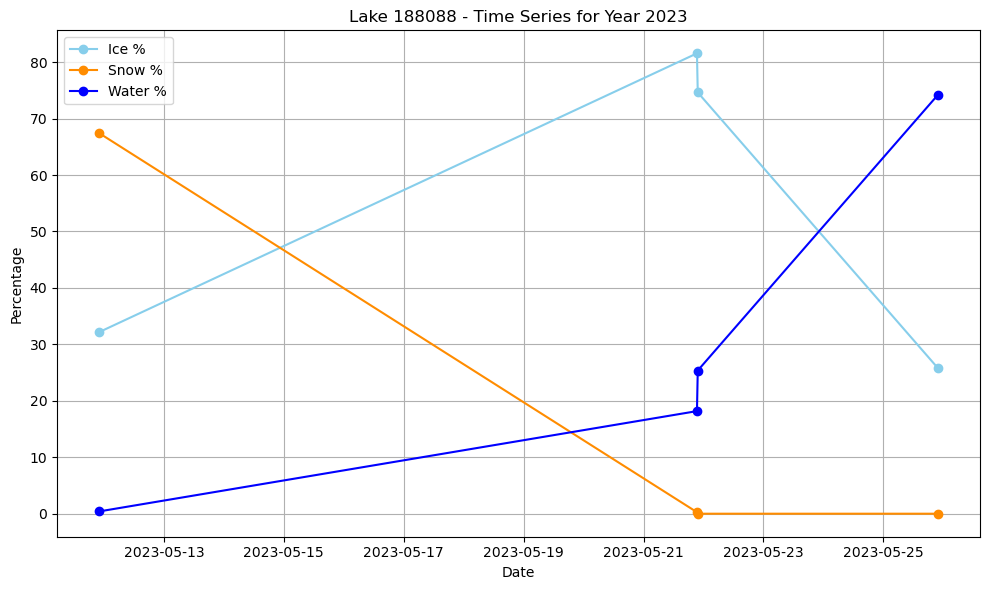

In [ ]:
# Plots the time series for the given lake ID above, organized by year
plot_time_series_for_lake(netcdf_path, lake_id)

In [ ]:
"""The functions below all work together to make a GIF of the time series for a given lake ID,
constructed from all the available images.  The GIF is output to a given folder and also shown in jupyter."""

def find_image_paths(base_dir, prefixes):
    """Find full paths for image files matching given prefixes."""
    
    matching_images = []
    
    for prefix in prefixes:
        search_pattern = os.path.join(base_dir, '**', f'{prefix}.tif')
        matches = glob.glob(search_pattern, recursive=True)
        
        if matches:
            matching_images.extend(matches)
        else:
            print(f"Warning: No image found for prefix {prefix}")
    
    return sorted(matching_images)

def get_lake_polygon(shapefile_path, lake_id):
    """Retrieve the polygon and CRS for a specific lake from ALPOD shapefile."""
    
    gdf = gpd.read_file(shapefile_path)
    lake_row = gdf[gdf['id'] == lake_id]
    
    if len(lake_row) == 0:
        print(f"No lake found with ID {lake_id}")
        return None, None
    
    return lake_row.geometry.iloc[0], lake_row.crs

def create_lake_bounds(lake_polygon, polygon_crs, src_crs):
    """
    Create a bounding box for the lake, transformed to the source CRS.
    
    Args:
        lake_polygon (shapely.geometry.Polygon): Lake polygon
        polygon_crs (pyproj.CRS): CRS of the original polygon
        src_crs (pyproj.CRS): Target CRS to transform to
    
    Returns:
        tuple: Bounding box coordinates (left, bottom, right, top)
    """
    
    # Create transformer
    transformer = Transformer.from_crs(polygon_crs, src_crs, always_xy=True)
    
    # Transform polygon coordinates
    transformed_coords = []
    for x, y in lake_polygon.exterior.coords:
        transformed_x, transformed_y = transformer.transform(x, y)
        transformed_coords.append((transformed_x, transformed_y))
    
    # Create a new polygon with transformed coordinates
    transformed_polygon = gpd.GeoSeries([shapely.geometry.Polygon(transformed_coords)], crs=src_crs)[0]
    
    # Get the geographic bounds
    left, bottom, right, top = transformed_polygon.bounds
    
    # Calculate the current width and height
    width = right - left
    height = top - bottom
    
    # Add 500m to sides 
    left -= 500
    right += 500
    bottom -= 500
    top += 500
    
    # Make it a square by taking the larger dimension
    square_size = max(right - left, top - bottom)
    
    # Center the square on the original bounds
    center_x = (left + right) / 2
    center_y = (bottom + top) / 2
    
    half_square = square_size / 2
    
    # Adjust bounds to create a square
    left = center_x - half_square
    right = center_x + half_square
    bottom = center_y - half_square
    top = center_y + half_square
    
    return (left, bottom, right, top)

def process_image(image_path, lake_bounds, lake_polygon=None, polygon_crs=None, downsample_factor=4, title=None):
    """
    Read, crop, and process a geotiff image with lake polygon overlay.
    """
    
    with rasterio.open(image_path) as src:
        # Crop to the lake bounds
        out_image, out_transform = rasterio.mask.mask(
            src, 
            [box(*lake_bounds)], 
            crop=True, 
            nodata=0
        )
        
        # Reorder bands from BGR NIR to RGB
        rgb_bands = out_image[[2, 1, 0]]  # Red, Green, Blue
        
        # Downsample
        downsampled_image = rgb_bands[:, ::downsample_factor, ::downsample_factor]
        
        # Transpose to (height, width, channels)
        downsampled_image = np.transpose(downsampled_image, (1, 2, 0))
        
        # Normalize to 0-255 range
        downsampled_image = ((downsampled_image - downsampled_image.min()) / 
                             (downsampled_image.max() - downsampled_image.min()) * 255).astype(np.uint8)
        
        # Convert to PIL Image for further processing
        pil_image = Image.fromarray(downsampled_image)  # Using PIL's Image directly
        draw = ImageDraw.Draw(pil_image, 'RGBA')
        
        # Overlay lake polygon if provided
        if lake_polygon is not None and polygon_crs is not None:
            try:
                # Transform polygon to image coordinates using the lake bounds transform
                transformer = Transformer.from_crs(polygon_crs, src.crs, always_xy=True)
                
                # Transform polygon coordinates
                transformed_coords = []
                for x, y in lake_polygon.exterior.coords:
                    # Transform geographic coordinates
                    transformed_x, transformed_y = transformer.transform(x, y)
                    
                    # Convert to pixel coordinates relative to the cropped image
                    pixel_x, pixel_y = ~out_transform * (transformed_x, transformed_y)
                    
                    # Downsample the coordinates
                    transformed_coords.append((
                        int(pixel_x / downsample_factor), 
                        int(pixel_y / downsample_factor)
                    ))
                
                # Darker, less saturated red with lower opacity
                red_outline_colors = [
                    (180, 0, 0, 200),  # Outer line - darker, less opaque
                    (180, 0, 0, 0),    # Middle line completely clear
                    (180, 0, 0, 200)   # Inner line - darker, less opaque
                ]
                
                # Draw thinner outlines
                for thickness, color in zip(range(3, 0, -1), red_outline_colors):
                    draw.polygon(transformed_coords, 
                                 outline=(*color[:3], color[3]), 
                                 fill=None)
                
            except Exception as e:
                print(f"Error transforming polygon: {e}")
        
        # Add title if provided
        if title:
            try:
                font = ImageFont.truetype("arial.ttf", 12)  # Reduced font size
            except IOError:
                font = ImageFont.load_default()
            
            # Add title with a semi-transparent background
            text_bbox = draw.textbbox((0, 0), title, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            draw.rectangle([0, 0, text_width + 10, text_height + 10], 
                           fill=(200, 200, 200, 128))
            
            draw.text((5, 5), title, font=font, fill=(0, 0, 0))
        
        return np.array(pil_image)

def get_lake_data_from_netcdf(netcdf_path, lake_id):
    """
    Get lake data from vlen NetCDF structure.
    
    Args:
        netcdf_path (str): Path to the NetCDF file
        lake_id (int): ID of the lake to process
    
    Returns:
        tuple: (lake_index, prefixes_list, observation_data)
    """
    
    with nc.Dataset(netcdf_path, 'r') as ncfile:
        # Find the lake's index in the lake array
        lake_ids = ncfile.variables['lake_id'][:]
        try:
            lake_idx = np.where(lake_ids == lake_id)[0][0]
        except IndexError:
            print(f"Lake ID {lake_id} not found in the dataset.")
            return None, None, None
        
        # Get the count of observations for this lake
        obs_count = ncfile.variables['obs_count'][lake_idx]
        
        if obs_count == 0:
            print(f"No observations found for Lake ID {lake_id}")
            return lake_idx, [], None
        
        # For variable-length arrays, we directly access the arrays for the specific lake
        # Variable-length arrays are indexed by lake
        datetimes = ncfile.variables['datetime'][lake_idx]  # This returns a numpy array
        
        # Handle prefix access - it's a comma-separated string for each lake
        prefix_raw = ncfile.variables['prefix'][lake_idx]
        
        # Convert to string if needed
        if isinstance(prefix_raw, bytes):
            prefix_str = str(prefix_raw, 'utf-8')
        else:
            prefix_str = str(prefix_raw)
        
        # Split by commas to get individual prefixes
        prefixes = [p.strip() for p in prefix_str.split(',')]
        
        # Extract observation data (optional - for additional processing)
        observation_data = {
            'datetimes': datetimes,
            'prefixes': prefixes,
            'ice_percent': ncfile.variables['ice_percent'][lake_idx],
            'water_percent': ncfile.variables['water_percent'][lake_idx],
            'snow_percent': ncfile.variables['snow_percent'][lake_idx]
        }
        
        return lake_idx, prefixes, observation_data

def generate_lake_gif(netcdf_path, lake_id, base_dir, output_dir, shapefile_path, year=2021, 
                     downsample_factor=4, display_gif=False):
    """
    Generate a GIF of lake images for a specific year with lake-centered zoom.
    Updated to work with ragged array NetCDF structure.
    
    Args:
        netcdf_path (str): Path to the ragged array NetCDF file
        lake_id (int): ID of the lake to process
        base_dir (str): Base directory for input images
        output_dir (str): Directory to save output GIF
        shapefile_path (str): Path to the lake shapefile
        year (int, optional): Year to process. Defaults to 2021.

        display_gif (bool, optional): Whether to display the GIF. Defaults to False.
    
    Returns:
        str or None: Path to the generated GIF, or None if generation fails
    """
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the output path
    output_path = os.path.join(output_dir, f'lake_{lake_id}_{year}_timelapse.gif')
    
    # Check if GIF already exists
    if os.path.exists(output_path):
        print(f"GIF already exists at {output_path}. Skipping generation.")
        
        # Optional display
        if display_gif:
            try:
                from IPython.display import Image, display
                with open(output_path, 'rb') as f:
                    display(Image(data=f.read(), format='gif'))
            except ImportError:
                print("Cannot display GIF: Not in a Jupyter environment")
        
        return output_path
    
    # Get lake polygon and its CRS
    lake_polygon, polygon_crs = get_lake_polygon(shapefile_path, lake_id)
    
    if lake_polygon is None:
        print(f"Could not find polygon for Lake ID {lake_id}")
        return None
    
    # Get lake data using the vlen array approach
    _, prefixes, observation_data = get_lake_data_from_netcdf(netcdf_path, lake_id)
    
    if not prefixes:
        print(f"No prefixes found for Lake ID {lake_id}")
        return None
    
    # Filter prefixes for the specified year if we have datetimes
    year_prefixes = []
    
    # Check if we have datetime information
    if observation_data and 'datetimes' in observation_data and len(observation_data['datetimes']) > 0:
        # Use datetime information to filter by year
        for i, dt_val in enumerate(observation_data['datetimes']):
            if isinstance(dt_val, (int, np.integer)):
                # Convert Unix timestamp to datetime
                dt = datetime.datetime.fromtimestamp(dt_val)  # Use datetime.datetime
                if dt.year == year and i < len(prefixes):
                    year_prefixes.append(prefixes[i])
    else:
        # Fallback to string filtering if no datetime information
        year_prefixes = [p for p in prefixes if str(year) in p]
    
    if not year_prefixes:
        print(f"No prefixes found for Lake ID {lake_id} in year {year}")
        return None
    
    # Find image paths and sort chronologically
    image_paths = find_image_paths(base_dir, year_prefixes)
    
    if not image_paths:
        print(f"No images found for Lake ID {lake_id} in year {year}")
        return None
    
    # Sort image paths chronologically
    image_paths.sort()
    
    # Prepare images for GIF
    images = []
    
    # Use the first image to get CRS for lake bounds
    with rasterio.open(image_paths[0]) as first_src:
        lake_bounds = create_lake_bounds(lake_polygon, polygon_crs, first_src.crs)
    
    for i, path in enumerate(tqdm(image_paths, desc="Processing images")):
        try:
            # Extract filename as title
            filename = os.path.splitext(os.path.basename(path))[0]
            
            # Add alphabetic label
            label = chr(65 + i)  # A, B, C, etc.
            title = f"{label}: {filename}"
            
            # Process image with lake bounds, polygon overlay, and title
            processed_image = process_image(
                path, lake_bounds, 
                lake_polygon=lake_polygon,
                polygon_crs=polygon_crs,
                downsample_factor=downsample_factor, 
                title=title
            )
            images.append(processed_image)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    # Create GIF
    if images:
        imageio.mimsave(output_path, images, fps=2)
        print(f"GIF saved to {output_path}")
        
        # Optional display (only in Jupyter environments)
        # Update the display section
    if display_gif:
        try:
            with open(output_path, 'rb') as f:
                display(IPythonImage(data=f.read(), format='gif'))  # Using IPythonImage
        except ImportError:
            print("Cannot display GIF: Not in a Jupyter environment")
        
        return output_path
    else:
        print("No images could be processed.")
        return None

def loop_gif(gif_path, num_loops=100):
    """
    Display a GIF repeatedly in a Jupyter Notebook
    """
    try:
        # Open the GIF to get its duration
        with Image.open(gif_path) as img:  # Using PIL's Image
            # Calculate total GIF duration (in seconds)
            # Default to 2 seconds if no duration found
            try:
                duration = img.n_frames / 2  # Assuming 2 fps from original code
            except AttributeError:
                duration = 2

        for _ in range(num_loops):
            # Clear previous output
            clear_output(wait=True)
            
            # Display the GIF
            display(IPythonImage(filename=gif_path, embed=True))  # Using IPythonImage
            
            # Wait for the duration of the GIF
            time.sleep(duration)

    except ImportError:
        print("Cannot loop GIF: Not in a Jupyter environment")
    except Exception as e:
        print(f"Error looping GIF: {e}")


# Example usage in __main__
if __name__ == "__main__":
    base_dir = r'D:\planetscope_lake_ice\Data (Unclassified)\1 - Break Up Time Series Input'
    output_dir = r'D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\Visualization GIFs'
    shapefile_path = r'D:\planetscope_lake_ice\Data (Validation)\8 - Download ALPOD data here\ALPODlakes.shp'
    netcdf_path = r'D:\planetscope_lake_ice\Data (Unclassified)\2 - Break Up Time Series Output\lake_statistics.nc'
    
    # Generate GIF for lake ID
    generate_lake_gif(
        netcdf_path=netcdf_path,
        lake_id=lake_id,
        base_dir=base_dir,
        output_dir=output_dir,
        shapefile_path=shapefile_path,
        year=2023,
        display_gif=True
    )